In [3]:
import numpy as np
import networkx as nx
from networkx.algorithms.community import girvan_newman
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import SGD
import torch.optim as optim
import random
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


## Найти набор данных для бинарной классификации рёбер в графе.

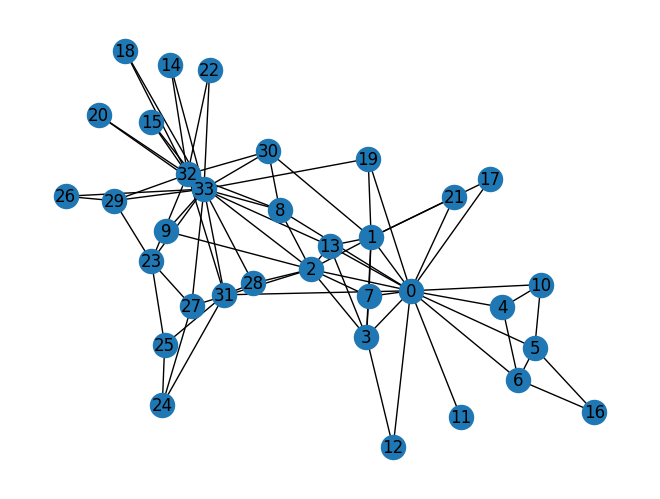

In [4]:
# Посмотрим на реальный граф Karate Club Network, показывающий кто из учеников общается вне занятий.
# После конфликта администратора и инструктора такой граф был использован для разделения учеников на два новых клуба.

G = nx.karate_club_graph()
nx.draw(G, with_labels=True)

## Реализовать случайные блуждания алгоритма **DeepWalk** и построить множества схожих вершин

In [5]:
def DeepWalkAlg(G, num_of_paths=10, len_of_path=10, t=5):
  num_of_nodes = G.number_of_nodes() # число узлов
  embedding = torch.nn.Embedding(num_embeddings=num_of_nodes, embedding_dim=num_of_nodes) # эмбеддинги
  positive_nodes, negative_nodes = [], [] # массивы вершин, которые были встречены/не встречены при обходе

  '''а) По каждой вершине графа'''
  for i in range(num_of_nodes):
    # инициализация текущей частоты посещения соседних вершин; списков встретившихся вершин
    cur_embedding, cur_pos_nodes = np.zeros(num_of_nodes), []

    '''б) По каждому блуждающему пути'''
    for j in range(num_of_paths):
      # собираем множество посещенных вершин
      nodes_in_path = set()
      cur_node = i
      nodes_in_path.add(cur_node) # добавляем текущую вершину

      '''в) По каждому шагу пути'''
      for k in range(len_of_path):
        # формирование списка доступных соседей для перехода
        available_neighbors = []
        for neighb in G.neighbors(cur_node):
          available_neighbors.append(neighb)
        # выбор next вершины + добавление её в список обхода + обновление cur вершины в блуждании
        next_node = random.choice(available_neighbors)
        nodes_in_path.add(next_node)
        cur_node = next_node

      # обновление числа посещений вершин + обновления множества посещенных вершин
      for nodes in nodes_in_path:
        cur_embedding[nodes] += 1
        cur_pos_nodes.append(nodes)

    #список не посещенных вершин
    neg_samples = np.where(cur_embedding == 0)[0]

    # отбор t непосещенных вершин
    cur_neg_nodes = np.random.choice(neg_samples, size=t, replace=True)

    #вероятность встретить каждую из вершин при обходе
    embedding.weight.data[i] = torch.Tensor(cur_embedding / num_of_paths)

    #сохранение списков посещенных и непосещенных вершин при обходе
    positive_nodes.append(cur_pos_nodes)
    negative_nodes.append(cur_neg_nodes)

  return embedding, positive_nodes, np.array(negative_nodes)


# Получаем всю матрицу эмбеддингов, а также списки позитивных и негативных вершин.
embedding, pos_nodes, neg_nodes = DeepWalkAlg(G)

Для визуализации пространства эмбеддингов снизим их размерность до 2 с помощью PCA и расскрасим двумя цветами (кто пошел в какой из двух клубов).

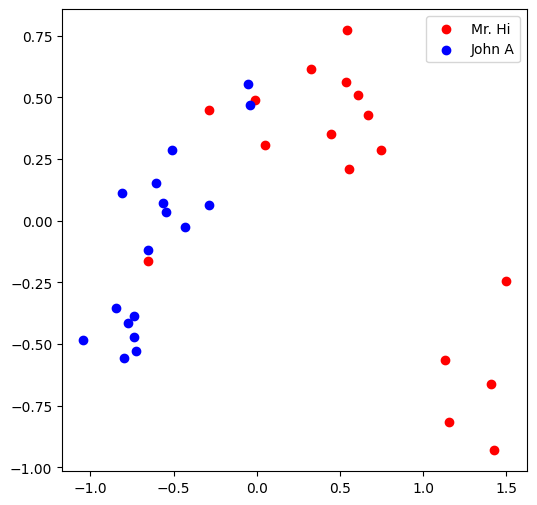

In [6]:
def visualize_emb(emb):
  X = emb.weight.data.numpy()
  pca = PCA(n_components=2)
  components = pca.fit_transform(X)
  plt.figure(figsize=(6, 6))
  club1_x = []
  club1_y = []
  club2_x = []
  club2_y = []
  for node in G.nodes(data=True):
    if node[1]['club'] == 'Mr. Hi':
      club1_x.append(components[node[0]][0])
      club1_y.append(components[node[0]][1])
    else:
      club2_x.append(components[node[0]][0])
      club2_y.append(components[node[0]][1])
  plt.scatter(club1_x, club1_y, color="red", label="Mr. Hi")
  plt.scatter(club2_x, club2_y, color="blue", label="John A")
  plt.legend()
  plt.show()

visualize_emb(embedding)

## Обучить эмбеддинги вершин, используя SGD и negative sampling.

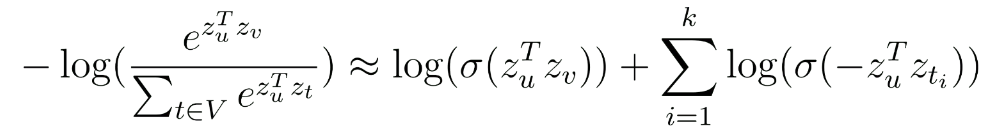

In [7]:
def my_loss(emb, pos_nodes, neg_nodes):

  V = len(emb.weight.data)
  L = 0
  for u in range(V):
    Nr_u = pos_nodes[u]
    for v in Nr_u:
      ZuT_Zv = torch.sum(torch.mul(emb.weight[u], emb.weight[int(v)]), axis=0)
      L += torch.log(torch.sigmoid(ZuT_Zv))
      k = neg_nodes[u]
    for i in k:
      ZuT_ZTi = torch.sum(torch.mul(emb.weight[u], emb.weight[int(i)]), axis = 0)
      L += torch.log(torch.sigmoid(-ZuT_ZTi))
  return -L

def train(emb, pos_nodes, neg_nodes, epochs=100):
  optimizer = SGD(emb.parameters(), lr=0.01, momentum=0.9)
  for i in range(epochs):
    optimizer.zero_grad()
    loss = my_loss(emb, pos_nodes, neg_nodes)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
      if i % 20 == 0:
        visualize_emb(emb)
        print(loss)

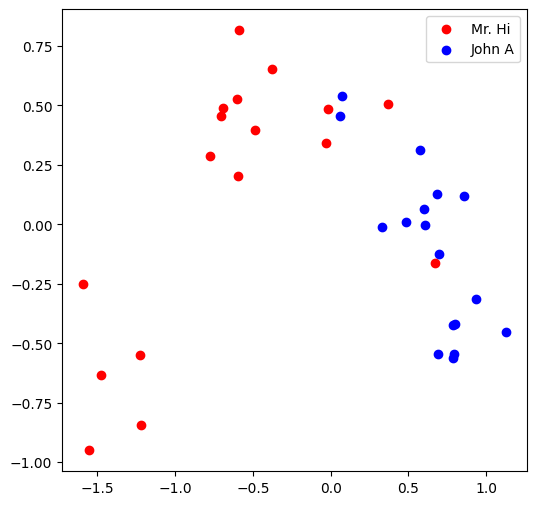

tensor(516.2462, grad_fn=<NegBackward0>)


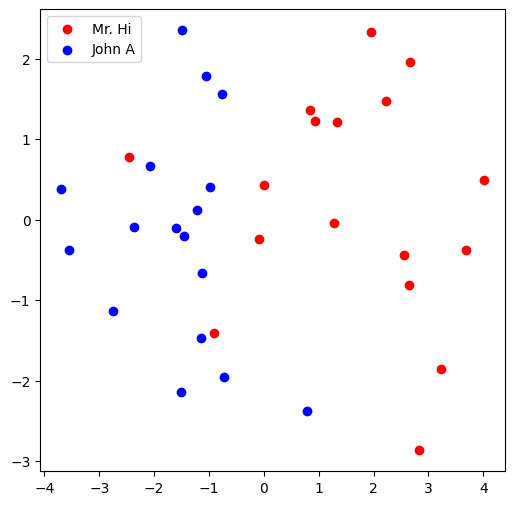

tensor(179.4397, grad_fn=<NegBackward0>)


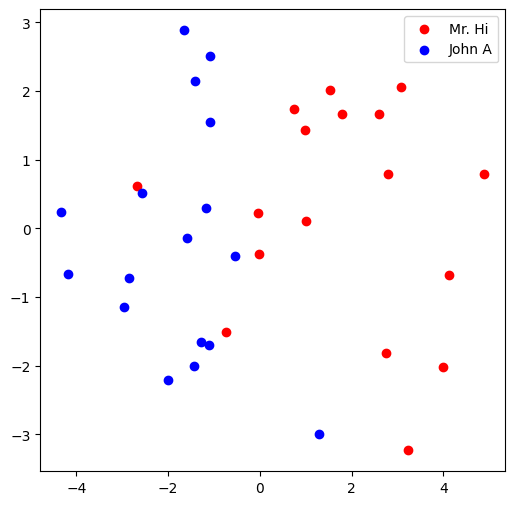

tensor(161.5798, grad_fn=<NegBackward0>)


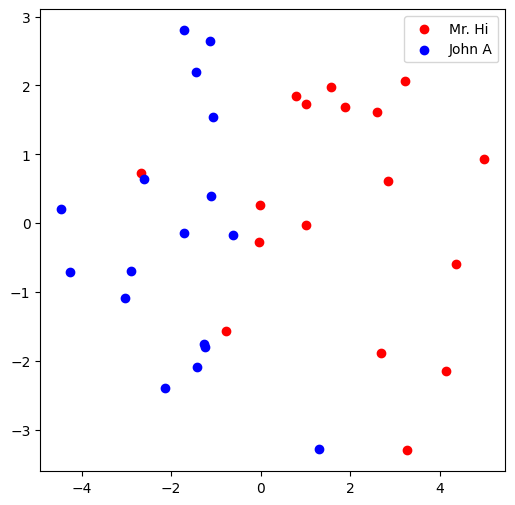

tensor(159.5739, grad_fn=<NegBackward0>)


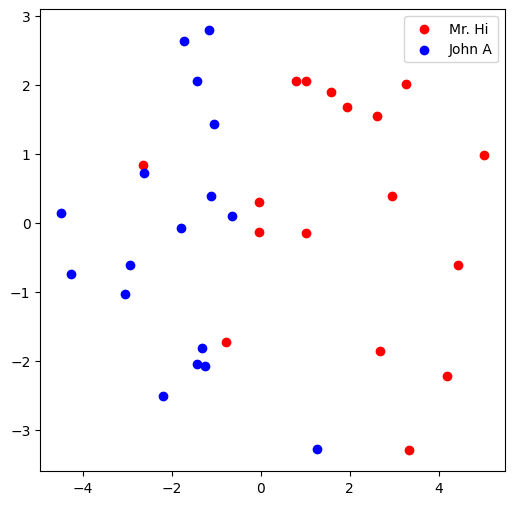

tensor(159.2657, grad_fn=<NegBackward0>)


In [8]:
EPOCHS = 100
train(embedding, pos_nodes, neg_nodes, EPOCHS)

Видно, что обучение модели происходит, но на последних эпохах уже значение loss-функции почти не изменяется, причем классы уже труднее становится визуально отделять => далее обучать не нужно, иначе можно поймать переобучение.

## (+5 баллов) Также реализовать **node2vec** блуждания и обучить классификатор, используя его. Сравнить результаты.

In [9]:
def Node2VecAlg(G, num_of_paths=10, len_of_path=10, t=5, p=1, q=0.5):
  num_of_nodes = G.number_of_nodes() # число узлов
  embedding = torch.nn.Embedding(num_embeddings=num_of_nodes, embedding_dim=num_of_nodes) # эмбеддинги
  positive_nodes, negative_nodes = [], [] # массивы вершин, которые были встречены/не встречены при обходе

  '''а) По каждой вершине графа'''
  for i in range(num_of_nodes):
    # инициализация текущей частоты посещения соседних вершин; списков встретившихся вершин
    cur_embedding, cur_pos_nodes = np.zeros(num_of_nodes), []

    # предыдущая вершина + множество соседей для предыдущей вершины
    pred_node = i
    available_neighbors_pred_node = set()

    '''б) По каждому блуждающему пути'''
    for j in range(num_of_paths):
      # собираем множество посещенных вершин
      nodes_in_path = set()
      cur_node = i
      nodes_in_path.add(cur_node) # добавляем текущую вершину

      '''в) По каждому шагу пути'''
      for k in range(len_of_path):
        available_neighbors = [] # список доступных соседей для перехода на каждом шаге

        for neighb in G.neighbors(cur_node):
          # заполнение массива соседей с учетом параметров p и q
          if neighb == pred_node:
            for f in range(int(1/p)):
              available_neighbors.append(neighb)
          elif neighb in available_neighbors_pred_node:
            available_neighbors.append(neighb)
          else:
            for f in range(int(1/q)):
              available_neighbors.append(neighb)

        # выбор next вершины + добавление её в список обхода + обновление cur вершины в блуждании
        next_node = random.choice(available_neighbors)
        pred_node = cur_node
        nodes_in_path.add(next_node)
        cur_node = next_node
        #обновление множества соседей предыдущей вершины
        for f in range(len(available_neighbors)):
          available_neighbors_pred_node.add(available_neighbors[f])

      # обновление числа посещений вершин + обновления множества посещенных вершин
      for nodes in nodes_in_path:
        cur_embedding[nodes] += 1
        cur_pos_nodes.append(nodes)

    #список не посещенных вершин
    neg_samples = np.where(cur_embedding == 0)[0]

    # отбор t непосещенных вершин
    cur_neg_nodes = np.random.choice(neg_samples, size=t, replace=True)

    #вероятность встретить каждую из вершин при обходе
    embedding.weight.data[i] = torch.Tensor(cur_embedding / num_of_paths)

    #сохранение списков посещенных и непосещенных вершин при обходе
    positive_nodes.append(cur_pos_nodes)
    negative_nodes.append(cur_neg_nodes)

  return embedding, positive_nodes, np.array(negative_nodes)


# Получаем всю матрицу эмбеддингов, а также списки позитивных и негативных вершин.
embedding2, pos_nodes2, neg_nodes2 = Node2VecAlg(G)

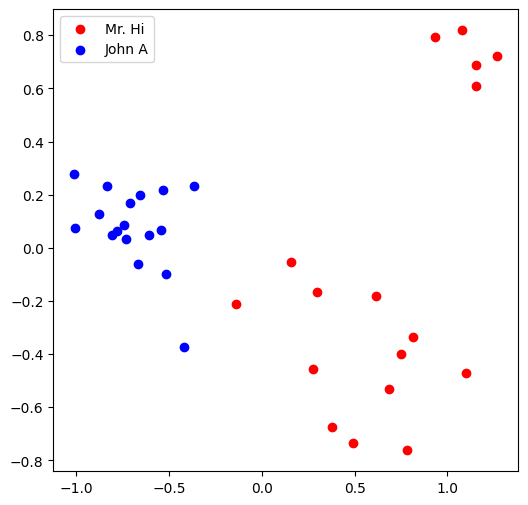

In [10]:
# Visualize the initial random embedding
visualize_emb(embedding2)

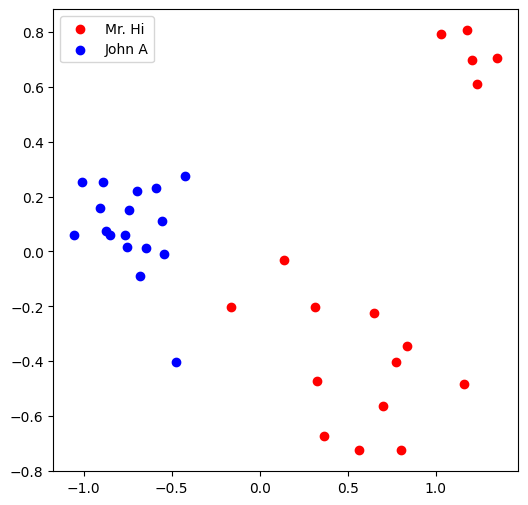

tensor(542.1821, grad_fn=<NegBackward0>)


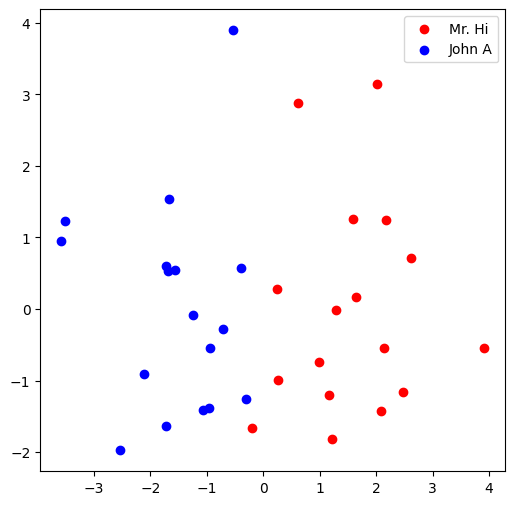

tensor(215.8499, grad_fn=<NegBackward0>)


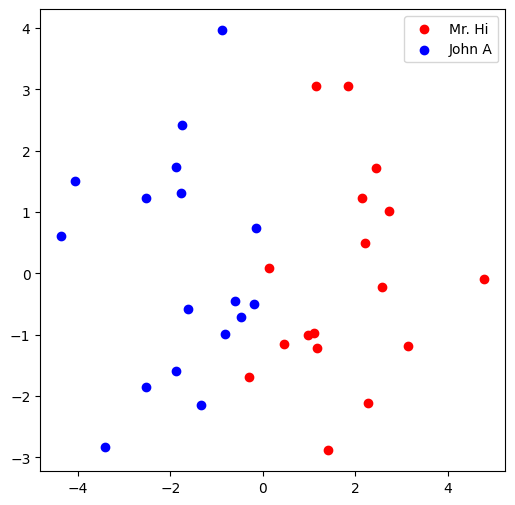

tensor(193.8596, grad_fn=<NegBackward0>)


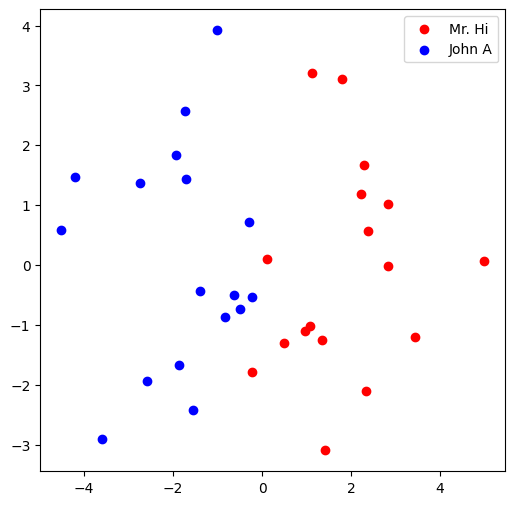

tensor(191.3412, grad_fn=<NegBackward0>)


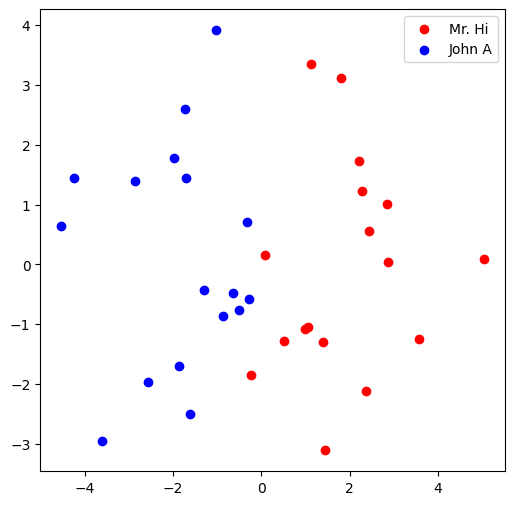

tensor(190.9545, grad_fn=<NegBackward0>)


In [11]:
train(embedding2, pos_nodes2, neg_nodes2, EPOCHS)

## Вывод

Во втором случае (при использовании node2vec) видим, что нет выбросов, классы отделяются четче. Также можно заметить, что необходимое число эпох обучения модели во втором случае должно быть меньше, т.к. быстрее наступает "выход на насыщение" loss-функции.

В целом, можно сказать, что алгоритм Node2Vec проявил себя лучше, чем DeepWalk при бинарной классификации вершин графа.
